In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Survey Specifications 

In [3]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

In [4]:
nu_obs = [353, 545, 857] # Planck effective freq. in GHz

# load Planck filter response curves 
from galCIB.utils.io import load_my_filters

cib_filters = load_my_filters("/Users/tkarim/research/galCIB/data/filters/",
                nu_obs=nu_obs)

In [5]:
from galCIB import Survey 

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
binned_ell_ledges = np.logspace(np.log10(LMIN), np.log10(LMAX),
                                20)
NSIDE = 1024 
#mag_alpha = 2.225 
mag_alpha = 1 #FIXME: turn on mag bias 

elg_survey = Survey(z=zs, 
                 pz=pz, mag_alpha=mag_alpha,  # galaxy-specific
                 cib_filters=cib_filters,  # dict: freq_GHz -> (freq_array_Hz, response_array)
                 ells=ells, nside=NSIDE, 
                 binned_ell_ledges=binned_ell_ledges,
                 name="DESI-Planck")

Cosmology object

In [6]:
ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

from galCIB import Cosmology

cosmo = Cosmology(elg_survey.z, ks, Mh, 
                  colossus_cosmo_name='planck18',
                  use_little_h=False)

# Calculate window 
elg_survey.compute_windows(cosmo,True)

In [7]:
# Setup galaxy HOD
from galCIB import get_hod_model
elg_hod_model = get_hod_model("DESI-ELG", cosmo)

In [8]:
# Setup Satellite Profile Model 
from galCIB import SatProfile
#theta_sat = np.array([0.58, 6.14, 0.67])
theta_sat = np.array([0., 6.14, 1]) # no unfw
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='mixed')

/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:37: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


In [9]:
from galCIB import SFRModel

# IR-emitting galaxies  HOD model 
hod_IR = get_hod_model("Zheng05", cosmo)

# Default SFR model
sfr_model = SFRModel(name="M21", hod=hod_IR, fsub=0.134)

In [10]:
from galCIB import SnuModel, CIBModel

# Non-parametric Snu model (M21)
snu_model_M21 = SnuModel(name="M21",
                         survey=elg_survey,
                         cosmo=cosmo,
                         nu_prime=np.array([353, 545, 857]))

# Initialize CIB model
cib_M21 = CIBModel(sfr_model=sfr_model, 
                   snu_model=snu_model_M21,
                   hod_IR=hod_IR
                   )

PkBuilder

In [12]:
from galCIB import PkBuilder

# M21 
pk_survey_M21 = PkBuilder(hod_model=elg_hod_model,
                          cib_model=cib_M21,
                          prof_model=elg_sat_profile)

Compute $C(\ell)$

In [13]:
from galCIB import AnalysisModel

analysis = AnalysisModel(survey=elg_survey,
                         pk3d=pk_survey_M21)

#### Test updating of params

Make sure each proposal updates power spectra. 

In [44]:
theta_sfr = {}
theta_snu = {}
theta_IR  = {}

theta_cen = np.array([3.28, 11.49, 0.45, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.38, 10**11.14, 10**13., 0.59]) # As, M0, M1, alpha_sat
theta_prof = np.array([0.52, 9.07, 0.7]) # fexp, tau, lambda_NFW
#theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

theta_sfr_M21 = np.array([0.49, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.52,-0.02, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc
theta_snu_M21 = None 
theta_IR_M21 = np.array([11.38, 2.6, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

theta_sfr_Y23 = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.78,0.4, #mu0_peak, mup_peak
                      2.47,0.45,1.93]) #sigmaM0, tau, zc
theta_snu_Y23 = np.array([5e-14, 1.98,21.13, 0.21, 1.7]) # L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR_Y23 = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

theta_sfr['M21'] = theta_sfr_M21
theta_snu['M21'] = theta_snu_M21
theta_IR['M21'] = theta_IR_M21

theta_sfr['Y23'] = theta_sfr_Y23
theta_snu['Y23'] = theta_snu_Y23 
theta_IR['Y23'] = theta_IR_Y23

shotnoise_gCIB = np.array([-1.8, -1.71, -2.24])
shotnoise_gCIB = 10**(shotnoise_gCIB - 2) # convert Y23 unit of 1e-8 MJy/sr to Jy/sr

# order is 353x353, 353x545, 353x857, 545x545, 545x857, 857x857
# taken from table 6 of 1309.0382, Planck 2013 CIB guesses
shotnoise_CIBCIB = np.array([225, 543, 913, 1454, 2655, 5628])

In [29]:
snu = 'M21'
bcen, cgg0, cgI0, cII0 = analysis.update_cl(theta_cen=theta_cen,
                                      theta_sat=theta_sat,
                                      theta_prof=theta_prof,
                                      theta_sfr=theta_sfr[snu],
                                      theta_snu=theta_snu[snu],
                                      theta_IR_hod=theta_IR[snu],
                                      theta_sn_gI=shotnoise_gCIB,
                                      theta_sn_II=shotnoise_CIBCIB,
                                      hmalpha=1,
                                      bin_cl=True)

set Ncen_IR = 1 for testing.


/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


## Test `update_cl` method

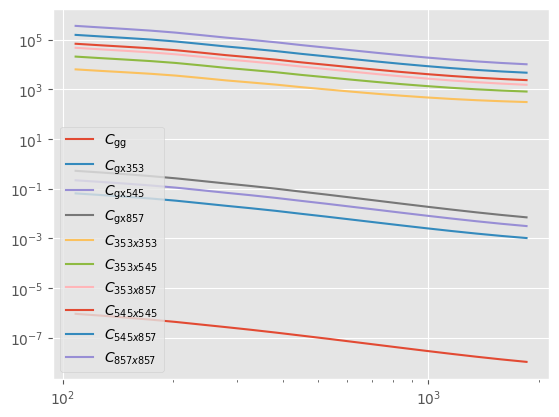

In [30]:

plt.loglog(bcen, cgg0, label = r'$C_{\rm gg}$')

nulist = ['353', '545', '857']
for i in range(3):
    plt.loglog(bcen, cgI0[i,:],
               label = fr'$C_{{\rm gx{nulist[i]}}}$')
    
for i in range(6):
    a,b = pk_survey_M21.twoh_pairs[i]
    plt.loglog(bcen, cII0[i,:],
               label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$')
    

plt.legend(loc='best',fontsize=10)

Change only `theta_cen`. 

This should not affect CII. 

In [32]:
theta_cen_new = np.array([3.28, 12.49, 0.45, 0.1]) # gamma, log10Mc, sigmaM, Ac

In [33]:
snu = 'M21'
_, cgg1, cgI1, cII1 = analysis.update_cl(theta_cen=theta_cen_new,
                                      theta_sat=theta_sat,
                                      theta_prof=theta_prof,
                                      theta_sfr=theta_sfr[snu],
                                      theta_snu=theta_snu[snu],
                                      theta_IR_hod=theta_IR[snu],
                                      theta_sn_gI=shotnoise_gCIB,
                                      theta_sn_II=shotnoise_CIBCIB,
                                      hmalpha=1,
                                      bin_cl=True)

set Ncen_IR = 1 for testing.


/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


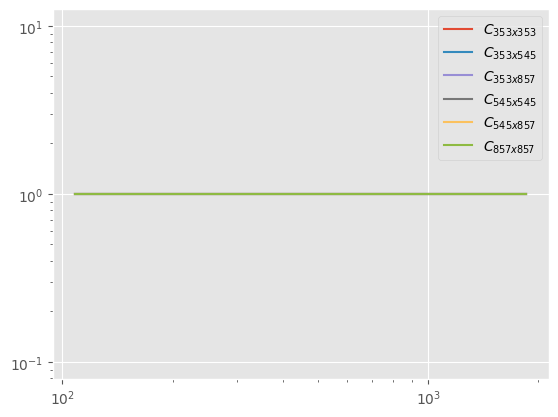

In [34]:
# plt.loglog(bcen, cgg0, label = r'$C_{\rm gg}$')

# nulist = ['353', '545', '857']
# for i in range(3):
#     plt.loglog(bcen, cgI0[i,:],
#                label = fr'$C_{{\rm gx{nulist[i]}}}$')
    
for i in range(6):
    a,b = pk_survey_M21.twoh_pairs[i]
    plt.loglog(bcen, cII0[i,:]/cII1[i,:],
               label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$')
    

plt.legend(loc='best',fontsize=10)

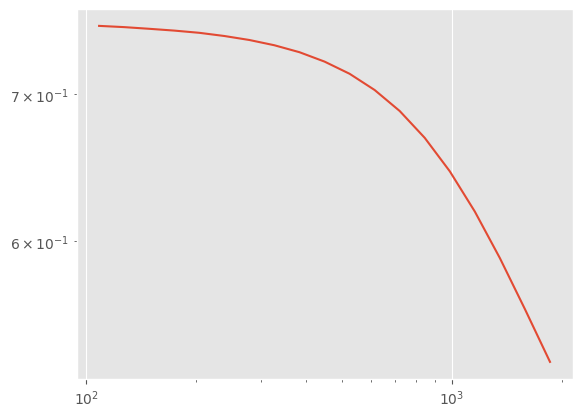

In [35]:
plt.loglog(bcen, cgg0/cgg1, label = r'$C_{\rm gg}$')

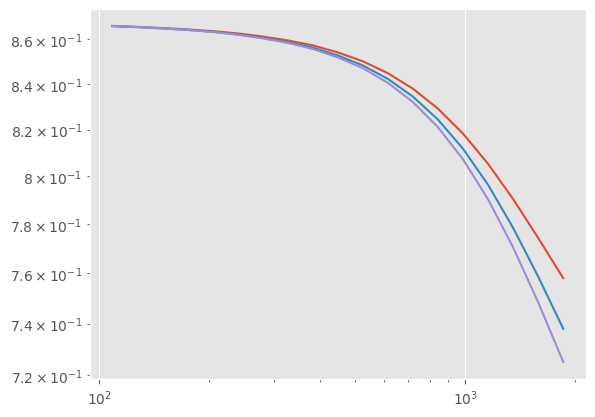

In [36]:
nulist = ['353', '545', '857']
for i in range(3):
    plt.loglog(bcen, cgI0[i,:]/cgI1[i,:],
               label = fr'$C_{{\rm gx{nulist[i]}}}$')

Change only `theta_prof` 

In [37]:
theta_prof_new = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

In [38]:
snu = 'M21'
_, cgg2, cgI2, cII2 = analysis.update_cl(theta_cen=theta_cen,
                                      theta_sat=theta_sat,
                                      theta_prof=theta_prof_new,
                                      theta_sfr=theta_sfr[snu],
                                      theta_snu=theta_snu[snu],
                                      theta_IR_hod=theta_IR[snu],
                                      theta_sn_gI=shotnoise_gCIB,
                                      theta_sn_II=shotnoise_CIBCIB,
                                      hmalpha=1,
                                      bin_cl=True)

set Ncen_IR = 1 for testing.


/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


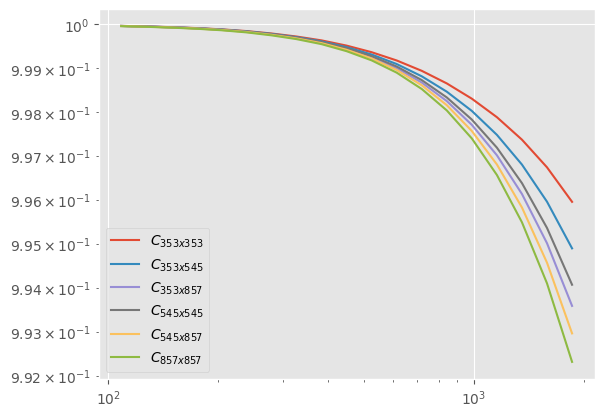

In [40]:
for i in range(6):
    a,b = pk_survey_M21.twoh_pairs[i]
    plt.loglog(bcen, cII0[i,:]/cII2[i,:],
               label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$')
    

plt.legend(loc='best',fontsize=10)

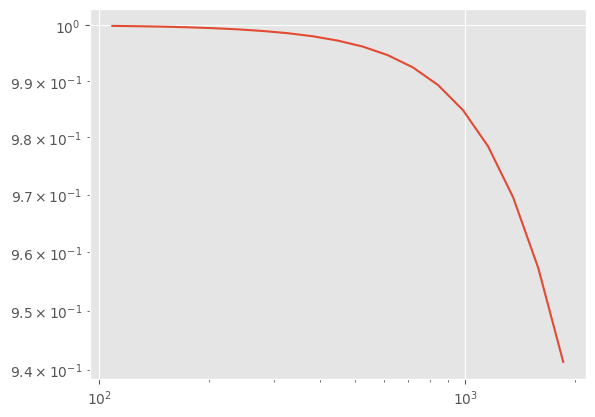

In [41]:
plt.loglog(bcen, cgg0/cgg2, label = r'$C_{\rm gg}$')

Change only `theta_sfr`

In [43]:
theta_sfr_M21_new = np.array([0.49, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      12.52,-0.02, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc

In [45]:
snu = 'M21'
bcen, cgg3, cgI3, cII3 = analysis.update_cl(theta_cen=theta_cen,
                                      theta_sat=theta_sat,
                                      theta_prof=theta_prof,
                                      theta_sfr=theta_sfr_M21_new,
                                      theta_snu=theta_snu[snu],
                                      theta_IR_hod=theta_IR[snu],
                                      theta_sn_gI=shotnoise_gCIB,
                                      theta_sn_II=shotnoise_CIBCIB,
                                      hmalpha=1,
                                      bin_cl=True)

set Ncen_IR = 1 for testing.


/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


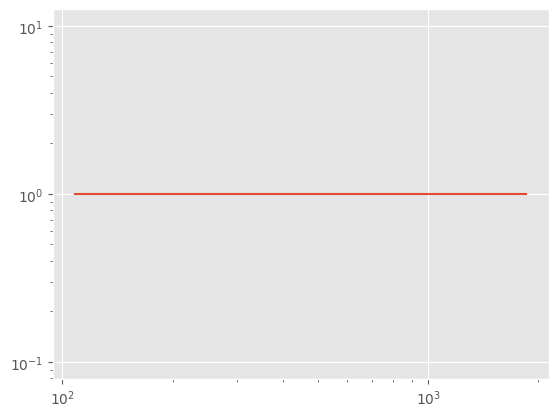

In [46]:
plt.loglog(bcen, cgg0/cgg3, label = r'$C_{\rm gg}$')

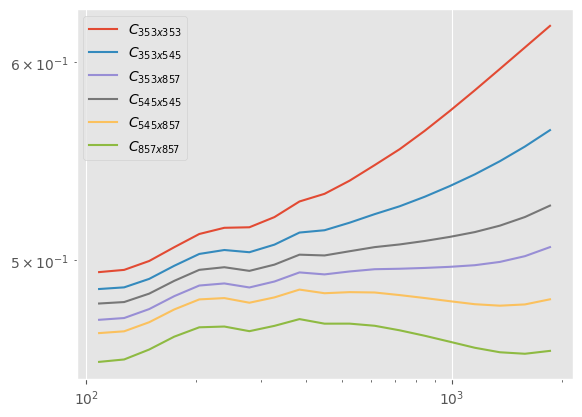

In [47]:
for i in range(6):
    a,b = pk_survey_M21.twoh_pairs[i]
    plt.loglog(bcen, cII0[i,:]/cII3[i,:],
               label = fr'$C_{{{nulist[a]}x{nulist[b]}}}$')
    

plt.legend(loc='best',fontsize=10)

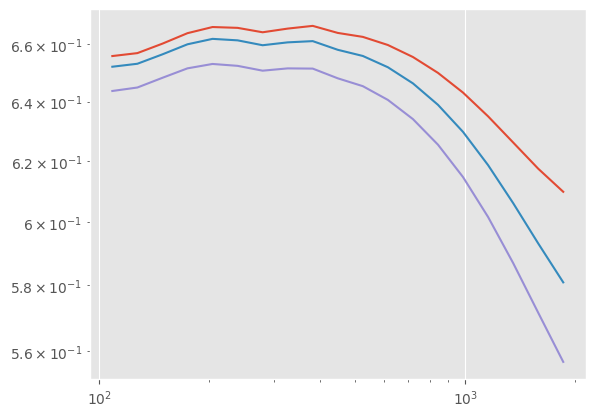

In [48]:
nulist = ['353', '545', '857']
for i in range(3):
    plt.loglog(bcen, cgI0[i,:]/cgI3[i,:],
               label = fr'$C_{{\rm gx{nulist[i]}}}$')

Change only `hmalpha`

In [54]:
snu = 'M21'
_, cgg4, cgI4, cII4 = analysis.update_cl(theta_cen=theta_cen,
                                      theta_sat=theta_sat,
                                      theta_prof=theta_prof,
                                      theta_sfr=theta_sfr[snu],
                                      theta_snu=theta_snu[snu],
                                      theta_IR_hod=theta_IR[snu],
                                      theta_sn_gI=shotnoise_gCIB,
                                      theta_sn_II=shotnoise_CIBCIB,
                                      hmalpha=0.7,
                                      bin_cl=True)

set Ncen_IR = 1 for testing.


/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


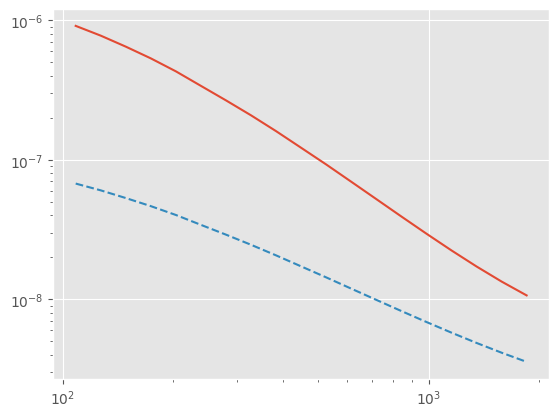

In [55]:
plt.loglog(bcen, cgg0, label = r'$C_{\rm gg}$')
plt.loglog(bcen, cgg4, ls = '--')

# Likelihood function 

In [56]:
def theta_wrapper(theta_cen, theta_sat, theta_prof,
                  theta_sfr, theta_snu, theta_IR_hod,
                  theta_sn_gI, theta_sn_II, 
                  theta_hmalpha):
    """
    Combines all theta into one array to pass 
    to MCMC sampler.
    """
    
    theta_final = np.concatenate((theta_cen, theta_sat,
                                  theta_prof, theta_sfr, 
                                  theta_snu, theta_IR_hod,
                                  theta_sn_gI, theta_sn_II,
                                  theta_hmalpha))
    
    return theta_final 

Todo:
- how to fix certain params, e.g., `theta_snu` should NOT
be sampled for M21. 

In [65]:
test_theta = theta_wrapper(theta_cen=theta_cen,
                                      theta_sat=theta_sat,
                                      theta_prof=theta_prof,
                                      theta_sfr=theta_sfr[snu],
                                      theta_snu=np.array([1]),
                                      theta_IR_hod=theta_IR[snu],
                                      theta_sn_gI=shotnoise_gCIB,
                                      theta_sn_II=shotnoise_CIBCIB,
                                      theta_hmalpha=np.array([1]))

In [68]:
#FIXME: setup class that reads in at least one 
#instance of theta and learns the parsing lengths

lcen = len(theta_cen)
lsat = len(theta_sat)
lprof = len(theta_prof)
lsfr = len(theta_sfr[snu])
lsnu = 1
lIR = len(theta_IR[snu])
lsn_gI = len(shotnoise_gCIB)
lsn_II = len(shotnoise_CIBCIB)
lhmalpha = 1



In [90]:

def theta_parser(theta):
    """
    Function that parses theta array into information
    that AnalysisModel.update_cl can understand.
    """
    
    countr = lcen
    countl = 0
    theta_cen = theta[:countr]
    
    countr += lsat
    countl += lcen
    theta_sat = theta[countl:countr]
    
    countr += lprof
    countl += lsat
    theta_prof = theta[countl:countr]
    
    countr += lsfr
    countl += lprof
    theta_sfr = theta[countl:countr]
    
    countr += lsnu
    countl += lsfr
    theta_snu = theta[countl:countr]
    
    countr += lIR
    countl += lsnu
    theta_IR_hod = theta[countl:countr]
    
    countr += lsn_gI
    countl += lIR
    theta_sn_gI = theta[countl:countr]
    
    countr += lsn_II
    countl += lsn_gI
    theta_sn_II = theta[countl:countr]
    
    countl += lsn_II
    theta_hmalpha = theta[countl:]
    
    return theta_cen, theta_sat, theta_prof, \
        theta_sfr, theta_snu, theta_IR_hod, \
            theta_sn_gI, theta_sn_II, theta_hmalpha

In [96]:
tcen, tsat, tprof, \
    tsfr, tsnu, tir, \
        tsngi, tsnii, tha = theta_parser(test_theta)

In [110]:
np.concatenate((cgg0, cgI0.flatten(), cII0.flatten()))

array([9.14904131e-07, 7.78453866e-07, 6.49077449e-07, 5.34633945e-07,
       4.31518109e-07, 3.39378004e-07, 2.67060058e-07, 2.08613502e-07,
       1.60613649e-07, 1.22022527e-07, 9.26284461e-08, 6.96291676e-08,
       5.22758035e-08, 3.92133494e-08, 2.95268499e-08, 2.23899081e-08,
       1.71734859e-08, 1.33866334e-08, 1.06466109e-08, 6.47028680e-02,
       5.57170385e-02, 4.76958511e-02, 4.02737973e-02, 3.29898963e-02,
       2.60737455e-02, 2.05373826e-02, 1.63486122e-02, 1.28092628e-02,
       9.77493547e-03, 7.53271993e-03, 5.73793214e-03, 4.36958671e-03,
       3.33143614e-03, 2.55735842e-03, 1.98261784e-03, 1.56088665e-03,
       1.25403838e-03, 1.03205228e-03, 2.18228996e-01, 1.87797144e-01,
       1.60466731e-01, 1.35173092e-01, 1.10493399e-01, 8.72327345e-02,
       6.86752967e-02, 5.45400527e-02, 4.25982423e-02, 3.24369970e-02,
       2.49045193e-02, 1.88836527e-02, 1.42991925e-02, 1.08223689e-02,
       8.23112070e-03, 6.30853831e-03, 4.89835653e-03, 3.87268003e-03,
      

In [130]:
def loglikelihood(theta):
    tcen, tsat, tprof, tsfr, \
        tsnu, tir, tsngi, \
            tsnii, tha = theta_parser(theta)
            
    _, cgg, cgI, cII = analysis.update_cl(theta_cen=tcen,
                                      theta_sat=tsat,
                                      theta_prof=tprof,
                                      theta_sfr=tsfr,
                                      theta_snu=tsnu,
                                      theta_IR_hod=tir,
                                      theta_sn_gI=tsngi,
                                      theta_sn_II=tsnii,
                                      hmalpha=tha,
                                      bin_cl=True)
    
    model = np.concatenate((cgg, cgI.flatten(), cII.flatten()))
    m_d = model - data 
    log_ll = m_d @ invcov @ m_d # Gaussian likelihood
    
    #return model
    return log_ll

In [129]:
#FIXME: dummy data 
cov = np.eye(190)
invcov = np.linalg.inv(cov)
data = loglikelihood(test_theta)

## note that I changed the likelihood funciton after this to get 
# likelihood and not model 

set Ncen_IR = 1 for testing.


In [131]:
loglikelihood(test_theta)

set Ncen_IR = 1 for testing.


0.0

In [132]:
test_theta2 = theta_wrapper(theta_cen=theta_cen,
                                      theta_sat=theta_sat,
                                      theta_prof=theta_prof_new,
                                      theta_sfr=theta_sfr[snu],
                                      theta_snu=np.array([1]),
                                      theta_IR_hod=theta_IR[snu],
                                      theta_sn_gI=shotnoise_gCIB,
                                      theta_sn_II=shotnoise_CIBCIB,
                                      theta_hmalpha=np.array([1]))

In [134]:
loglikelihood(test_theta2)

/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


set Ncen_IR = 1 for testing.


43344.96501396831

##### Test case

1D test where we sample $\mu_{0,\rm{peak}}$ uniformly from 11 to 12.

In [138]:
mu0p_grid = np.linspace(11, 12, 50)

array([11.        , 11.02040816, 11.04081633, 11.06122449, 11.08163265,
       11.10204082, 11.12244898, 11.14285714, 11.16326531, 11.18367347,
       11.20408163, 11.2244898 , 11.24489796, 11.26530612, 11.28571429,
       11.30612245, 11.32653061, 11.34693878, 11.36734694, 11.3877551 ,
       11.40816327, 11.42857143, 11.44897959, 11.46938776, 11.48979592,
       11.51020408, 11.53061224, 11.55102041, 11.57142857, 11.59183673,
       11.6122449 , 11.63265306, 11.65306122, 11.67346939, 11.69387755,
       11.71428571, 11.73469388, 11.75510204, 11.7755102 , 11.79591837,
       11.81632653, 11.83673469, 11.85714286, 11.87755102, 11.89795918,
       11.91836735, 11.93877551, 11.95918367, 11.97959184, 12.        ])

In [141]:
theta_sfr_tmp = theta_sfr['M21'].copy()

array([ 0.49, 11.52, -0.02,  2.74,  0.5 ,  2.15])

In [144]:
log_ll_mu0p = np.zeros_like(mu0p_grid)

for i in range(50):
    theta_sfr_tmp[1] = mu0p_grid[i]
    
    tt = theta_wrapper(theta_cen=theta_cen,
                       theta_sat=theta_sat,
                        theta_prof=theta_prof_new,
                        theta_sfr=theta_sfr_tmp,
                        theta_snu=np.array([1]),
                        theta_IR_hod=theta_IR[snu],
                        theta_sn_gI=shotnoise_gCIB,
                        theta_sn_II=shotnoise_CIBCIB,
                        theta_hmalpha=np.array([1]))
    
    
    log_ll_mu0p[i] = loglikelihood(tt)

/Users/tkarim/research/galCIB/src/galCIB/galaxy/default_models.py:71: RuntimeWarning: invalid value encountered in power
  Nsat = np.where(Mh-M0 < 0, 0, As * ((Mh-M0)/M1)**alpha_sat)


set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 1 for testing.
set Ncen_IR = 

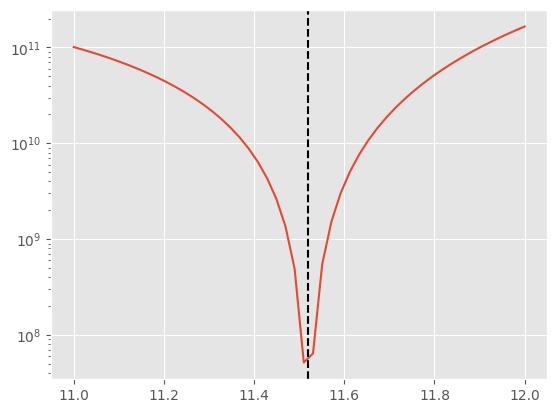

In [147]:
plt.semilogy(mu0p_grid, log_ll_mu0p)
plt.axvline(11.52, c = 'k', ls = '--')

# Priors 

In [ ]:
#FIXME: check if prior definition is properly done in log
# versus linear space 

def log_prior(theta):
    """
    Returns the prior probability 
    """
    
    gamma_cen, log10Mc, sigmaM_cen, Ac, \
        As, M0, M1, alpha_sat, \
            fexp, tau_sat, lambda_NFW, \
            etamax, mu0p, mupp, sigmaM0_sfr, tau_sfr, zc, \
                _, mu0_Mmin_IR, mup_Mmin_IR, sigma_lnM_IR, \
                sg3, sg5, sg8, \
                s33, s35, s38, s55, s58, s88, \
                hmalpha = theta
    
    # SFR conditions
    inf_cond = ((etamax<0.1)|(etamax>1.0)|\
               (mu0p<10)|(mu0p>14)|(mupp<-5)|(mupp>5)|\
               (sigmaM0_sfr<0.1)|(sigmaM0_sfr>4)|\
               (tau_sfr<0.)|(tau_sfr>1)|(zc<0.5)|(zc>3)|\
                (mu0_Mmin_IR<10)|(mu0_Mmin_IR>13)|\
                (mup_Mmin_IR<-5)|(mup_Mmin_IR>5)
                )
    
    # break before needing to check all conditions
    if inf_cond: 
        return -np.inf 
    
    # shot-noise conditions
    inf_cond = (
        (sg3 < -6)|(sg3 >-1)|(sg5 < -6)|(sg5 >-1)|\
        (sg8 < -6)|(sg8 >-1)
    )
    
    # break before needing to check all conditions
    if inf_cond: 
        return -np.inf 
        
    ## These priors are based on eyeballing
    # Fig 26 of 2306.06319
    
    # Ncen conditions
    log10M0 = np.log10(M0)
    
    inf_cond = ((gamma_cen<1.25)|(gamma_cen>8.5)|\
               (log10Mc<11.3)|(log10Mc>11.9)|\
               (sigmaM_cen<0.)|(sigmaM_cen>1)
               )
    
    # break before needing to check all conditions
    if inf_cond: 
        return -np.inf 
    
    #Nsat conditions
    inf_cond = ((As<0.)|(As>1.)|\
               (log10M0<10.5)|(log10M0>11.8)|\
                   (alpha_sat<-0.5)|(alpha_sat>1.5)|\
                    (fexp<0.)|(fexp>1.)|\
                        (tau_sat<1)|(tau_sat>11)|\
                        (lambda_NFW<0.)|(lambda_NFW>1.5)
                )
    
    
    # break before needing to check all conditions
    if inf_cond: 
        return -np.inf 
    
    return 0 # if inf_cond is False throughout 
    

In [ ]:


shotnoise_gCIB = np.array([-1.8, -1.71, -2.24])
shotnoise_gCIB = 10**(shotnoise_gCIB - 2) # convert Y23 unit of 1e-8 MJy/sr to Jy/sr

# order is 353x353, 353x545, 353x857, 545x545, 545x857, 857x857
# taken from table 6 of 1309.0382, Planck 2013 CIB guesses
shotnoise_CIBCIB = np.array([225, 543, 913, 1454, 2655, 5628])

In [153]:
-np.inf == -np.inf

True

In [155]:
import pickle 
dndz_all = pickle.load(open("/Users/tkarim/research/galCIB/data/gal/dndz_extended.p", "rb"))

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_48576/3109844831.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/tkarim/research/galCIB/data/gal/dndz_extended.p'>
  dndz_all = pickle.load(open("/Users/tkarim/research/galCIB/data/gal/dndz_extended.p", "rb"))


In [158]:
dndz_all['dndz'].mean(axis=0).shape

(30,)